In [1]:
import numpy as np
def phiExample(s, L1=1.0, L2=1.0):
    # Complex function with multiple peaks, valleys, and non-linearities
    x, y = s[0], s[1]
    
    # Multiple Gaussian bumps
    # Generate random bump positions within the L1, L2 boundaries
    bump_positions = [
        (0.2 * L1, 0.3 * L2), 
        (0.7 * L1, 0.8 * L2), 
        (0.5 * L1, 0.1 * L2), 
        (0.9 * L1, 0.5 * L2)
    ]
    bump_heights = [3, 4, 2, 5]
    bump_widths = [30, 40, 25, 35]
    
    bumps = 0
    for i in range(len(bump_positions)):
        pos_x, pos_y = bump_positions[i]
        height = bump_heights[i]
        width = bump_widths[i]
        bumps += height * np.exp(-width * ((x-pos_x)**2 + (y-pos_y)**2))
    
    # Sinusoidal variations
    # waves = 2 * np.sin(8 * np.pi * x) * np.cos(6 * np.pi * y)
    
    # Polynomial trend
    # trend = (x - 0.4)**2 * (y - 0.6)**2 * 5
    
    # Sharp ridge
    # ridge = 3 * np.exp(-100 * (x - y)**2)
    
    # Combine all components
    return bumps + 2
# Function to be used for phi with specific L1 and L2 values
def phi_func(s):
    return phiExample(s, L1=1.0, L2=1.0)

from my_erg_lib.agent import Agent
from my_erg_lib.obstacles import Obstacle, ObstacleAvoidanceControllerGenerator
from my_erg_lib.model_dynamics import SingleIntegrator, DoubleIntegrator, Quadcopter
from my_erg_lib.ergodic_controllers import DecentralisedErgodicController
from my_erg_lib.basis import ReconstructedPhi, ReconstructedPhiFromCk
import matplotlib.pyplot as plt
import vis
import time

def returnTime(K_max, test_mode=False):

    time_init = time.time()

    # Quadrotor model -----------
    x0 = [0.3, 0.5, 2, 0, 0, 0, 0,  0,  0,  0,  0,  0]
    UP_MTR_LIM = 2         # Motor Upper Limit Thrust in [N]
    LOW_MTR_LIM = -2       # Motor Lower Limit Thrust in [N]
    mtr_limits = [[LOW_MTR_LIM, UP_MTR_LIM], [LOW_MTR_LIM, UP_MTR_LIM], [LOW_MTR_LIM, UP_MTR_LIM], [LOW_MTR_LIM, UP_MTR_LIM]]
    model = Quadcopter(dt=0.001, x0=x0, z_target=2, motor_limits=mtr_limits, zero_out_states=["x", "y", "ψ"])
    TS = 0.1; T_H = 0.25*5; deltaT_ERG = 0.25 * 40
    Q_ = 1
    u_limits = model.input_limits
    u_nominal = model.calcLQRcontrol
    BAR_WEIGHT = 0 # 50

    # Agent - Ergodic Controller -------------
    # Generate Agent and connect to an ergodic controller object
    agent = Agent(L1=1.0, L2=1.0, Kmax=K_max, 
                    dynamics_model=model, phi=phi_func, x0=x0)

    agent.erg_c = DecentralisedErgodicController(agent, uNominal=u_nominal, Q=Q_, uLimits=u_limits,
                                                    T_sampling=TS, T_horizon=T_H, deltaT_erg=deltaT_ERG,
                                                    barrier_weight=BAR_WEIGHT, barrier_eps=0.05, barrier_pow=2)

    # Avoiding Obstacles -------------------
    # Add obstacles and another controller to take them into account
    FMAX = 0.25; EPS_M = 0.2
    obs  = [Obstacle(pos=[0.2, 0.2],   dimensions=0.1,        f_max=FMAX, min_dist=0.14, eps_meters=EPS_M, obs_type='circle',    obs_name="Obstacle 1"), 
            Obstacle(pos=[0.66, 0.77], dimensions=0.12,       f_max=FMAX, min_dist=0.16, eps_meters=EPS_M, obs_type='circle',    obs_name="Obstacle 2"), 
            Obstacle(pos=[0.6, 0.5],   dimensions=0.08,       f_max=FMAX, min_dist=0.12, eps_meters=EPS_M, obs_type='circle',    obs_name="Obstacle 3"),
            Obstacle(pos=[0.15, 0.8],  dimensions=[0.2, 0.2], f_max=FMAX, min_dist=0.14, eps_meters=EPS_M, obs_type='rectangle', obs_name="Obstacle 4")]

    agent.erg_c.uNominal += ObstacleAvoidanceControllerGenerator(agent, obs_list=obs, func_name="Obstacles")


    # Avoiding Walls ----------------------
    FMAX = 1; min_dist = 1e-2; EPS_M = 0.49; e_max = agent.L1
    bar  = [Obstacle(pos=[0,        0],   dimensions=[0, +1], f_max=FMAX, min_dist=min_dist, e_max=e_max, eps_meters=EPS_M,  obs_type='wall', obs_name="Bottom Wall"),
            Obstacle(pos=[0, agent.L2],   dimensions=[0, -1], f_max=FMAX, min_dist=min_dist, e_max=e_max, eps_meters=EPS_M,  obs_type='wall', obs_name="Top Wall"   ),
            Obstacle(pos=[0,        0],   dimensions=[+1, 0], f_max=FMAX, min_dist=min_dist, e_max=e_max, eps_meters=EPS_M,  obs_type='wall', obs_name="Left Wall"  ),
            Obstacle(pos=[agent.L1, 0],   dimensions=[-1, 0], f_max=FMAX, min_dist=min_dist, e_max=e_max, eps_meters=EPS_M,  obs_type='wall', obs_name="Right Wall" )]

    # Add the obstacle avoidance controller to the ergodic controller
    agent.erg_c.uNominal += ObstacleAvoidanceControllerGenerator(agent, obs_list=bar, func_name="Walls")
    # Print uNominal Status
    print(agent.erg_c.uNominal)

    # Lets now update the phi_function to take into account the obstacles
    agent.basis.phi = agent.modifedPhiForObstacles(agent.basis.phi, obs_to_exclude=["Obstacle 2", "Obstacle 3"])
    if not test_mode:
        agent.basis.precalcAllPhiK()

    return time.time() - time_init
# -----------------------------------------------------------------------------------


In [7]:
zero_out_time = np.mean([x for x in [returnTime(K_max, test_mode=True) for K_max in range(1, 10)]])
std_out_time = np.std([x for x in [returnTime(K_max, test_mode=True) for K_max in range(1, 10)]])  

zero_out_time_std = zero_out_time + std_out_time

k_list = np.arange(2, 15)
# Run each K_max 3 times and calculate mean and std
time_means = []
time_stds = []

for k in k_list:
    times = [returnTime(k) for _ in range(1)]
    time_means.append(np.mean(times))
    time_stds.append(np.std(times))

time_list = time_means

Motor Limits: 
 [[-2  2]
 [-2  2]
 [-2  2]
 [-2  2]]
Input Limits: 
 [[-8  8]
 [-8  8]
 [-8  8]
 [-8  8]]
Obstacle: Obstacle 1 	- k: 4.90e-03 	- e: 0.20[m] 	- type: circle 	- Pos: [0.2 0.2] 	- Dim: [0.1] 		 f_min: 5.44e-02 
Obstacle: Obstacle 2 	- k: 6.40e-03 	- e: 0.20[m] 	- type: circle 	- Pos: [0.66 0.77] 	- Dim: [0.12] 		 f_min: 6.25e-02 
Obstacle: Obstacle 3 	- k: 3.60e-03 	- e: 0.20[m] 	- type: circle 	- Pos: [0.6 0.5] 	- Dim: [0.08] 		 f_min: 4.59e-02 
Obstacle: Obstacle 4 	- k: 4.90e-03 	- e: (0.20[m], 0.20[m]) 	- type: rectangle 	- Pos: [0.15 0.8 ] 	- Dim: [0.2 0.2] 	 f_min: 5.44e-02 
Obstacle: Bottom Wall 	- k: 1.00e-04 	- e: 0.49[m] 	- type: wall 	- Pos: [0 0] 		- Normal: [0 1] 	 f_min: 4.16e-04 
Obstacle: Top Wall 	- k: 1.00e-04 	- e: 0.49[m] 	- type: wall 	- Pos: [0. 1.] 		- Normal: [ 0 -1] 	 f_min: 4.16e-04 
Obstacle: Left Wall 	- k: 1.00e-04 	- e: 0.49[m] 	- type: wall 	- Pos: [0 0] 		- Normal: [1 0] 	 f_min: 4.16e-04 
Obstacle: Right Wall 	- k: 1.00e-04 	- e: 0.49[m] 	-

In [8]:
# fit a polynomial to the data of degree DEG=2
DEG = 2
coeffs = np.polyfit(k_list, time_list, DEG)
# Create a polynomial function from the coefficients
poly_func = np.poly1d(coeffs)
# Generate x values for the fitted curve
x_fit = np.linspace(min(k_list), max(k_list), 100)
# Generate y values for the fitted curve
y_fit = poly_func(x_fit)

# Print the coefficients
print(f"Polynomial coefficients (degree {DEG}): {coeffs}")
# Print the time taken for each K_max
for k, t_mean, t_std in zip(k_list, time_means, time_stds):
    print(f"K_max: {k}, Time mean: {t_mean:.4f} s, Time std: {t_std:.4f} s")

Polynomial coefficients (degree 2): [0.01673247 0.02244835 0.05259334]
K_max: 2, Time mean: 0.1491 s, Time std: 0.0000 s
K_max: 3, Time mean: 0.2617 s, Time std: 0.0000 s
K_max: 4, Time mean: 0.4094 s, Time std: 0.0000 s
K_max: 5, Time mean: 0.5945 s, Time std: 0.0000 s
K_max: 6, Time mean: 0.8240 s, Time std: 0.0000 s
K_max: 7, Time mean: 1.0456 s, Time std: 0.0000 s
K_max: 8, Time mean: 1.3129 s, Time std: 0.0000 s
K_max: 9, Time mean: 1.6048 s, Time std: 0.0000 s
K_max: 10, Time mean: 1.9172 s, Time std: 0.0000 s
K_max: 11, Time mean: 2.3139 s, Time std: 0.0000 s
K_max: 12, Time mean: 2.6961 s, Time std: 0.0000 s
K_max: 13, Time mean: 3.1740 s, Time std: 0.0000 s
K_max: 14, Time mean: 3.6821 s, Time std: 0.0000 s


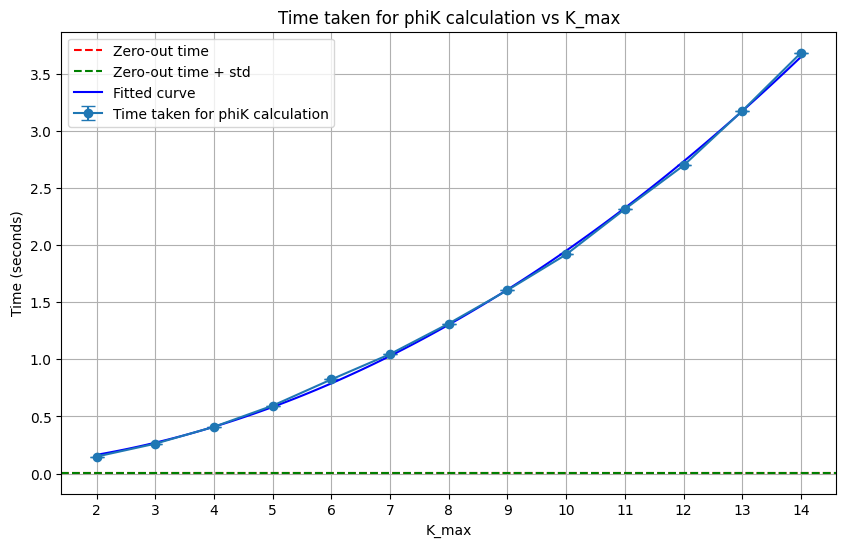

In [9]:

# Plot the results
plt.figure(figsize=(10, 6))
plt.errorbar(k_list, time_list, yerr=time_stds, fmt='o-', capsize=5, 
             label='Time taken for phiK calculation')
plt.axhline(y=zero_out_time, color='r', linestyle='--', label='Zero-out time')
plt.axhline(y=zero_out_time_std, color='g', linestyle='--', label='Zero-out time + std')
plt.plot(x_fit, y_fit, 'b-', label='Fitted curve')
plt.title('Time taken for phiK calculation vs K_max')
plt.xlabel('K_max')
plt.ylabel('Time (seconds)')
plt.xticks(k_list)
plt.grid()
plt.legend()
plt.show()
